# Práctica 2

Primero obtenemos y procesamos los datos con los que vamos a trabajar, comunes a ambos apartados de la práctica. En concreto, obtenemos los textos de entrenamiento y test y los vectorizamos con la frecuencia de aparicion de términos incluidos en el diccionario words.txt dado.

In [1]:
from sklearn.datasets import fetch_20newsgroups

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise        import cosine_similarity

In [2]:
# Obtención de los datos de entrenamiento y prueba
train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=17)
test_data  = fetch_20newsgroups(subset='test',  shuffle=True, random_state=398)

In [3]:
# Lectura del diccionario de palabras
with open('words.txt') as file:
    dictionary = file.read().splitlines()

In [4]:
# Vectorizador de documentos común a los apartados a y b
vectorizer = CountVectorizer(analyzer='word',stop_words='english', binary=False, vocabulary=dictionary, ngram_range=(1,1))

In [5]:
# Obtención de los datos vectorizados con respecto al diccionario
train_data_vectorized = vectorizer.fit_transform(train_data.data)
test_data_vectorized  = vectorizer.fit_transform(test_data.data)

Importamos librerías usadas en los siguientes apartados. Recomendamos crear una instancia de random con una semilla concreta en aquellas celdas donde se prentenda que el comportamiento no varíe entre ejecuciones. Esto es, para obtener aleatoriedad pero determinismo (aunque suene contradictorio). Se fija una semilla global que **puede verse afectada por cambios en el orden de ejecución de las celdas**. 

In [6]:
import random
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import pandas as pd

# Mucho cuidado con el uso que se hace de esta instancia
rand = random.Random(93854)

En la siguiente tabla mostramos las temáticas en las que se organizan los textos obtenidos. En lo sucesivo va a ser la norma manejar estas temáticas no por su nombre, sino por un código, que no es más que su índice en la lista de nombres de temáticas. Mostramos aquí la equivalencia temática-código como referencia para futuros apartados.

In [7]:
pd.DataFrame({'Código':range(20)},test_data.target_names)

,Código
alt.atheism,0
comp.graphics,1
comp.os.ms-windows.misc,2
comp.sys.ibm.pc.hardware,3
comp.sys.mac.hardware,4
comp.windows.x,5
misc.forsale,6
rec.autos,7
rec.motorcycles,8
rec.sport.baseball,9


Presentamos ahora una serie de funciones implementadas que serán útiles a lo largo de toda la práctica. 

Para entender el por qué de estas implementaciones cabe destacar que no trabajamos con los textos propiamente dichos, sino que representamos los textos por su índice en las variables train\_data y test\_data definidas anteriormente. Así por ejemplo, cuando llamamos a la función _get\_k\_mas\_similares_ para obtener los k textos más similares a uno dado, no obtenemos una lista de textos, sino una lista de índices de estos textos en train\_data.

In [8]:
# Muestra un texto y su categoría.
#
# docs:     train_data o test_data 
# text_idx: índice del texto seleccionado
def print_texto_y_categoria(docs, text_idx):
    print("---------------------------- TEXT ----------------------------")
    print(docs.data[text_idx])
    print("-------------------------- CATEGORY --------------------------")
    print(docs.target_names[docs.target[text_idx]])
    

# Esta función ha sido empleada únicamente en la visualización de textos
# en el testeo y desarrollo de la práctica para su comprensión y depuración.

In [9]:
# Devuelve una lista con los índices de k documentos seleccionados 
# aleatoriamente de entre aquellos de la categoría dada.
#
# docs:      train_data o test_data 
# k:         número de textos que seleccionar
# categoria: número de categoría en 20newsgroups [0-19]
def selecciona_k_textos_clase(docs,k,categoria):
    return rand.sample([idx for idx in range(len(docs.data)) if docs.target[idx]==categoria],k)


# Esta función es utilizada para obtener los textos con los que medir la
# precisión en nuestra búsquedas. Ha sido generalizada a más de tres textos
# para poder analizar la precisión más en profundidad.

In [10]:
# Devuelve una lista con los índices de los k textos más similares a uno
# dado ordenados de mayor a menor similitud.
#
# docs_vectorized: train_data o test_data vectorizados (admite TF-IDF)
# elem_vectorized: un texto cualquiera vectorizado
# k:               número de textos a recuperar
def get_k_mas_similares(docs_vectorized, elem_vectorized, k):
    similarities = cosine_similarity(docs_vectorized,elem_vectorized)
    return sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)[:k]


# Esta función es invocada para buscar los textos más similares a uno
# dado tanto en el apartado a como en el b (con datos TF-IDF)

In [11]:
# Devuelve la proporción de textos con índice en 'idxs' catalogados 
# en la categoría pasada como parámetro (para medir precisión de búsqueda).
#
# docs:      train_data o test_data
# idxs:      lista de índices de textos en docs
# categoria: categoría objetivo sobre la que calcular la proporción
def proporcion(docs, idxs, categoria):
    return len([i for i in idxs if docs.target[i]==categoria])/len(idxs)


# Esta función la empleamos para medir la precisión del resultado de 
# una búsqueda (proporción de textos en la categoría acertada).

Seleccionamos aleatoriamente tres textos de cada clase del conjunto de test para analizar con estos el funcionamiento de nuestro buscador. Como hemos explicado anteriormente, realmente seleccionamos índices de textos que apuntan directamente a su posición en la variable test_data.

In [12]:
# Para cada categoría, seleccionamos tres textos aleatoriamente
test_texts_idxs = [selecciona_k_textos_clase(test_data,3,i) for i in range(20)]

La siguiente función mide para cada una de las temáticas, para cada uno de los textos de test seleccionados en esa temática, la precisión en la búsqueda de los k textos más similares y además obtiene la media de estas precisiones organizadas por temáticas. En definitiva, es la que empleamos para medir la precisión de nuestro buscador en cada temática.

Por defecto toma los datos vectorizados con su frecuencia absoluta de palabras pero permite datos transformados con TF-IDF. Se incluye además una función para la visualización de estas precisiones por categorías.

In [13]:
# Devuelve una lista con la precisión media en cada temática en la 
# búsqueda de los k textos más similares a los dados.
# 
# k: número de elementos a recuperar por el buscador
# test_docs_idxs: lista con listas de índices de documentos en test_docs para cada temática
# test_docs: Contiene los documentos que componen los términos de búsqueda (vectorizados/tf-idf)
# all_docs:  Contiene los documentos sobre los que se realiza la búsqueda (vectorizados/tf-idf)
def precision_k_mas_similares(k,test_docs_idxs=test_texts_idxs, test_docs=test_data_vectorized,all_docs=train_data_vectorized):
    resultado = []
    for i in range(20): # Para cada temática
        avg_precision = 0
        for idx in test_docs_idxs[i]:   # Para cada documento de test calculamos la precisión
            idx_similares = get_k_mas_similares(all_docs, test_docs[idx], k)
            avg_precision += proporcion(train_data, idx_similares, i)
        avg_precision /= len(test_docs_idxs[i]) # Calculamos la precisión media en esta temática
        resultado.append(avg_precision) # Añadimos la precisión media a la lista resultado
    return resultado

# La empleamos para analizar la precisión en cada temática de nuestro
# buscador en los apartados a (docs vectorizados con frecuencias) y
# b (docs vectorizados tf-idf)

In [14]:
# Dada una lista de precisiones ([0,1]) para cada temática (20 elementos)
# muestra estas y su media gráficamente
def show(datos_precision):
    # Eje x: clase
    # Eje y: precisión
    # Línea azul: media
    plt.plot(range(20),datos_precision,'ro')
    plt.axis([-1,20,0,1])
    plt.axhline(y=sum(datos_precision)/len(datos_precision), linewidth=1, color = 'b')
    plt.show()
    
# La empleamos para representar el análisis de precisiones por temáticas
# devuelto por 'precision_k_mas_similares'

## Práctica 2.2.a

En esta parte de la práctica realizamos todos los cómputos (en concreto los relativos a la similitud de textos) con las variables **train_data_vectorized** y **test_data_vectorized** vectorizadas con la frecuencia absoluta de aparición de términos.

**Calcula la precisión de búsqueda para cada clase con niveles de exhaustividad 3 y 10**

In [15]:
# Calculamos y representamos la precisión al tomar los 3 docs. más similares
precision_3_v  = precision_k_mas_similares(3)

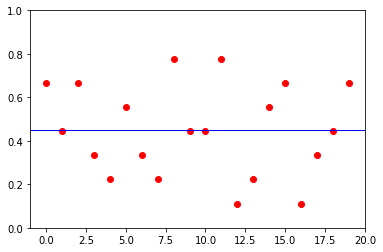

In [16]:
show(precision_3_v)

In [17]:
# Calculamos y representamos la precisión al tomar los 10 docs. más similares
precision_10_v = precision_k_mas_similares(10) 

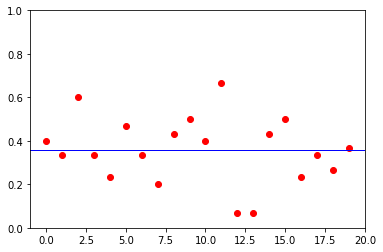

In [18]:
show(precision_10_v)

**¿Hay muchas diferencias entre los valores de precisión medios para las distintas clases del conjunto de datos? ¿A qué crees que se deben?**

OJO!: Hay que hablar un poco de la diferencia 3-10

Viendo las gráficas de precisión por temáticas es obvia la respuesta a la primera pregunta. Hay grandes diferencias en la precisión obtenida en las distintas temáticas, desde clases donde la precisión es de casi un 70% a clases donde no se alcanza un 10%. 

Vamos analizar nuestros datos más en detalle.

In [21]:
#Tabla de precisiones
d_v  = {'Precision Exhaus 3':precision_3_v,'Precision Exhaus 10':precision_10_v}
df_v = pd.DataFrame(data=d_v,index=test_data.target_names)

In [22]:
# Estadísticos principales
df_v.describe()

,Precision Exhaus 3,Precision Exhaus 10
count,20.000000,20.000000
mean,0.450000,0.358333
std,0.211664,0.155174
min,0.111111,0.066667
25%,0.305556,0.258333
50%,0.444444,0.350000
75%,0.666667,0.441667
max,0.777778,0.666667


Primero nótese al haber 20 temáticas distintas, si clasificáramos aleatoriamente los textos, sin un análisis de la información, la precisión esperada sería de tan solo un 5%. Esto significa que si nuestro buscador obtiene peores resultados debemos probar suerte en el mundo del parchis en vez de el mundo de la IA. Sin embargo, conociendo este umbral afirmamos que, pese a no obtener niveles de precisión realmente altos en ninguna clase (con 10 textos de test no se alcanza ni un 70% en ninguna), podemos afirmar que nuestro buscador obtiene buenos resultados. 

Sin embargo, como hemos mencionado, la precisión varía enormemente en función de la temática. Temáticas como 'sci.crypt' o 'comp.os.ms-windows.misc' obtienen una precisión de más del 60% con ambos niveles de exhaustividad frente a temáticas como 'sci.electronics' y 'sci.med' que obtienen resultados muy pobres con ambos clasificadores, rozando el umbral del fracaso que habíamos marcado en el 5%.

¿Qué puede causar esto? Pues bien, se nos ocurren dos posibilidades. 

La primera es que haya alguna temática íntimamente relacionada con estas que obtienen malos resultados y con un umbral difuso entre ambas. Si dos temáticas poseen por su propia naturaleza textos similares no podemos culpar a nuestro buscador de la confusión. Estamos diciendo a grandes rasgos que si en vez de tener la temática 'hockey' tuviéramos las temáticas 'hockey hierba' y 'hockey pista' nuestro buscador tendría dificultades con ciertos textos, recuperando textos entendidos como similares de ambas categorías, lo que penaliza la precisión como la entendemos en esta práctica (que puede no ser la mejor medida de precisión para gran cantidad de objetivos). Esto no nos parece la verdadera causa ni especialmente grave a la vista de los resultados aunque podría explicar la baja precisión de 'rec.autos' al existir una clase similar 'rec.motorcycles'.

La segunda posibilidad que se nos ocurre, y que consideramos la más probable, es que las temáticas de electrónica y medicina se distinguen precisamente por su jerga, abundante en tecnicismos y términos empleados en estos campos casi exclusivamente. Nosotros al estar literalmente desechando en nuestro análisis todos los términos de nuestros textos que no se encuentren en el diccionario words.txt podemos estar perdiendo este rasgo que distingue a estos textos tan específicos. En definitiva, si el diccionario no es lo suficientemente exhaustivo con estos campos, los textos de estas temáticas pierden precisamente lo que los distingue. En el siguiente apartado analizamos esto más en profundidad.

**Identifica la clase que haya tenido peores resultados de precisión y para alguna de sus consultas muestra alguno de los mensajes que recuperó erróneamente en las primeras X posiciones.**
* **¿Con qué clases se ha confundido más dicha consulta?**
* **¿A qué crees que se deben los malos resultados?**

Vamos a analizar el origen de las confusiones en la temática **sci.electronics** (código 12) que ha obtenido los peores resultados en exhaustividad 3 y 10.

In [23]:
textos_test_electronics = test_texts_idxs[12]

# Para ver los textos de testeo de la categoría sci.electronics
#print_texto_y_categoria(test_data, textos_test_electronics[0])
#print_texto_y_categoria(test_data, textos_test_electronics[1])
#print_texto_y_categoria(test_data, textos_test_electronics[2])

# Para obtener los 10 textos más similares a cada uno de test
similares_texto_1 = get_k_mas_similares(train_data_vectorized, test_data_vectorized[textos_test_electronics[0]],10)
similares_texto_2 = get_k_mas_similares(train_data_vectorized, test_data_vectorized[textos_test_electronics[1]],10)
similares_texto_3 = get_k_mas_similares(train_data_vectorized, test_data_vectorized[textos_test_electronics[2]],10)

# Para mostrar los textos más similares recuperados
#print_texto_y_categoria(train_data, similares_texto_1[0])
#print_texto_y_categoria(train_data, similares_texto_1[1])
#print_texto_y_categoria(train_data, similares_texto_1[2])
#print_texto_y_categoria(train_data, similares_texto_2[0])
#print_texto_y_categoria(train_data, similares_texto_2[1])
#print_texto_y_categoria(train_data, similares_texto_2[2])
#print_texto_y_categoria(train_data, similares_texto_3[0])
#print_texto_y_categoria(train_data, similares_texto_3[1])
#print_texto_y_categoria(train_data, similares_texto_3[2])

Primeramente decir que, analizando los textos de test que se tomaron aleatoriamente para esta categoría ya encontramos una anomalía. Uno de los textos es el siguiente

In [24]:
print_texto_y_categoria(test_data, textos_test_electronics[1])

---------------------------- TEXT ----------------------------
From: red@tina.dei.unipd.it (Piergiorgio Sartor 274199/IL)
Subject: PALs, GALs
Organization: D.E.I. Universita' di Padova -- Italia
Lines: 6

Does anyone know how can I get detailed information about PALs and GALs.
Please reply via e-mail.
Thanks a lot in advance.
-- 
					red@paola.dei.unipd.it
					red@maya.dei.unipd.it

-------------------------- CATEGORY --------------------------
sci.electronics


Este texto únicamente se podría clasificar en la categoría de electrónica en base a que PAL y GAL hacen referencia a sistemas de codificación de televisión analógica. Pues bien, PALs y GALs **no están en el diccionario** words.txt por lo que son excluidas del mensaje para el análisis del texto. Se trata entonces de recuperar similitudes con un mensaje con casi por completo palabras genéricas.

Mostramos ahora un mensaje recuperado de forma "errónea" (de otra categoría) considerado similar a uno de nuestros mensajes de test de la categoría sci.electronics.

In [25]:
print_texto_y_categoria(train_data, similares_texto_3[1])

---------------------------- TEXT ----------------------------
From: alin@nyx.cs.du.edu (ailin lin)
Subject: VGA card/1 meg wanted
Organization: Nyx, Public Access Unix @ U. of Denver Math/CS dept.
Lines: 7

it must have 1 meg memory and support res. 1024x768 (even higher will be better)if it has 9 & 15 pin ports and also supports ega/cga , that's better.
I will pay $30 + $1 (shipping) for it.

let me knoe if u have one like this.

ailin
803-654-8817

-------------------------- CATEGORY --------------------------
misc.forsale


Memory, VGA, ports, pin, card... Todos son términos frecuentes en el campo de la electrónica. La confusión con este texto es lógica en base al funcionamiento de búsqueda por vectores de términos. La aparición del término "pay" una única vez (en este apartado la frecuencia importa), muy frecuente en misc.foresale no es suficiente para distanciar este texto como vector de los textos de electrónica. Además, \\$30 y \\$1 no son palabras del diccionario pese a que son los mayores indicativos de que el texto es de carácter comercial. Si nos tuvieramos que enfrentar a este problema en un caso concreto nosotros trataríamos de detectar los símbolos \\$,€,£... y añadir el número de apariciones de estos como una coordenada más de los vectores de términos posiblemente con una ponderación elevada.

Finalmente, en respuesta a las preguntas de este apartado, vamos a analizar las confusiones de sci.electronics con las demás categorías y a concluir un por qué de estos malos resultados.

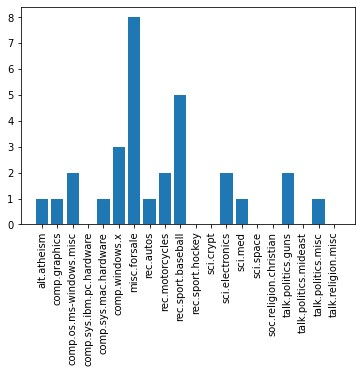

In [26]:
# Obtenemos los textos más similares para las consultas de test
similares = list(set().union(similares_texto_1,similares_texto_2,similares_texto_3))

# Calculamos la frecuencia de aparición de cada clase
frecuencias = [0]*20
for idx in similares:
    frecuencias[train_data.target[idx]] += 1;

# Mostramos el resultado como diagrama de barras
plt.bar(train_data.target_names,frecuencias)
plt.xticks(rotation='vertical')
plt.show()

Es claro entonces que la clase con la que más se confunden nuestros textos de test es con misc.forsale, categoría de artículos en venta pues, para alegría de China y para coherencia nuestra, estos artículos son muy ofertados y demandados y poseen el problema que hemos visto en el ejemplo de texto recuperado erróneamente. 

Nos atrevemos a decir además que este problema se debe también a que en un artículo de venta de una mesa, por ejemplo, se suelen indicar las medidas y el material del que esta está fabricada mientras que en un artículo de venta de un dispositivo electrónico se suelen indicar todas sus características técnicas. Esto contiene gran cantidad de términos del campo de la electrónica y contener estos términos es lo relevante para nuestro buscador. Esta combinación gran cantidad de venta de electrónica, especificaciones detallades en los artículos de venta es lo que crea la confusión. 

Sí que nos sorprende y no entendemos el por qué de la recuperación de textos de béisbol. Nos atrevemos a aventurar que el culpable es el texto de test explicado anteriormente que era puramente genérico.

## Práctica 2.2.b

En esta parte de la práctica realizamos todos los cómputos (en concreto los relativos a la similitud de textos) con las variables train_data_vectorized y test_data_vectorized transformadas con **tf-idf**.

**Calcula la precisión de búsqueda para cada clase con niveles de exhaustividad 3 y 10**

In [15]:
# Usamos los datos "train_data_vectorized" transformados con tf-idf
tfidfer = TfidfTransformer()
train_data_tfidf = tfidfer.fit_transform(train_data_vectorized)
test_data_tfidf = tfidfer.transform(test_data_vectorized)

In [16]:
precision_3_t  = precision_k_mas_similares(3, test_texts_idxs, test_data_tfidf, train_data_tfidf)

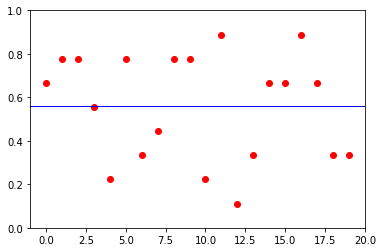

In [17]:
show(precision_3_t)

In [18]:
precision_10_t = precision_k_mas_similares(10, test_texts_idxs, test_data_tfidf, train_data_tfidf) 

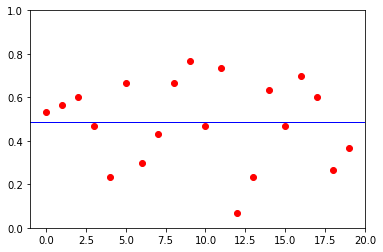

In [19]:
show(precision_10_t)

In [20]:
d_t = {'Precision Exhaus 3':precision_3_t,'Precision Exhaus 10':precision_10_t}
df_t = pd.DataFrame(data=d_t,index=test_data.target_names)
df_t

,Precision Exhaus 3,Precision Exhaus 10
alt.atheism,0.666667,0.533333
comp.graphics,0.777778,0.566667
comp.os.ms-windows.misc,0.777778,0.600000
comp.sys.ibm.pc.hardware,0.555556,0.466667
comp.sys.mac.hardware,0.222222,0.233333
comp.windows.x,0.777778,0.666667
misc.forsale,0.333333,0.300000
rec.autos,0.444444,0.433333
rec.motorcycles,0.777778,0.666667
rec.sport.baseball,0.777778,0.766667


In [21]:
df_t.describe()

,Precision Exhaus 3,Precision Exhaus 10
count,20.000000,20.000000
mean,0.561111,0.488333
std,0.245757,0.193543
min,0.111111,0.066667
25%,0.333333,0.350000
50%,0.666667,0.500000
75%,0.777778,0.641667
max,0.888889,0.766667


#### Comentarios

DUDA: no hace bien los enter si no es para nuevo párrafo, preguntar JC

Para nivel de exhaustividad 3, la media ha subido de un 0.539 a un 0.561, la desviación típica se mantiene similar, el primer cuantil ha mejorado de 0.33 a 0.41, la mediana ha empeorado de 0.61 a 0.55 y el tercer cuantil se mantiene. Esto quiere decir que los casos en los que había baja precisión han mejorado, pero en los que había alta se han mantenido estables.

Para nivel de exhaustividad 10, todo ha mejorado. Es especialmente notable que un 50% de las clases tienen más del 0.55 de precisión y un 25% de las clases tienen más del 0.675 de precisión, lo cual es muy positivo.

Nivel de exhaustividad 3:
Clases que han mejorado (7): 'comp.sys.ibm.pc.hardware', 'rec.autos', 'rec.sport.baseball', 'rec.sport.hockey', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast'
Clases que han empeorado (8): 'comp.os.ms-windows.misc', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.motorcycles', 'sci.electronics', 'sci.space', 'talk.politics.misc'
Clases que se mantienen (5): restantes

Nivel de exhaustividad 10:
Clases que han empeorado (2): 'alt.atheism', 'talk.politics.misc'
Clases que se mantienen (2): 'misc.forsale', 'talk.politics.mideast'
Clases que han mejorado (16): 'restantes'

Hay un empate entre las dos clases que más han mejorado con nivel de exhaustividad 10, así que escogemos de esas la que más ha mejorado con nivel de exhaustividad 3: 'sci.crypt'.

Tf-idf significa term-frequency times inverse document-frequency, es decir, minimiza el impacto de términos con frecuencias muy altas (y seguramente no informativos) y aumenta el impacto de términos con poca frecuencia (pero que pueden ser, por ejemplo, tecnicismos).

Veamos qué ha pasado en el caso concreto de 'sci.crypt' mostrando las frecuencias antes y después de usar tf-idf.
Lo compararemos con 'rec.sport.hockey', cuya precisión aumentó 0.13 al usar tf-idf frente a los 0.2 de 'sci.crypt', con el objetivo de visualizar entre que valores oscilan las frecuencias tras pasar por el tf-idf.
Como es una matriz dispersa, mostramos los valores de la versión comprimida en un array para poder verlos todos.

In [26]:
num_clase = test_data.target_names.index('rec.sport.hockey')
print(test_data_vectorized[num_clase].data)
print()
print(np.flip(test_data_tfidf[num_clase].data))
# Las tuplas aparecian en orden inverso, de ahí el flip

[1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 2 1 1 1 3 1 1 1
 1 1 1 1 1 1 1]

[0.09634314 0.12785479 0.10142332 0.07766332 0.10028107 0.10162125
 0.05531737 0.12881632 0.11303802 0.09903719 0.10329174 0.09649053
 0.08259555 0.12989615 0.14793198 0.07659876 0.08547652 0.19911877
 0.06789368 0.096197   0.06888689 0.07448095 0.09053712 0.09242015
 0.08800302 0.11840926 0.08299831 0.11642791 0.096197   0.1102043
 0.07811842 0.06471261 0.10894425 0.05587561 0.06216837 0.06485495
 0.09920951 0.16695768 0.15993586 0.12623671 0.06809356 0.08334125
 0.01737466 0.09649053 0.08077092 0.10243636 0.13743496 0.06433866
 0.01801596 0.08018382 0.16695768 0.10776971 0.08239763 0.06108132
 0.08516588 0.12005984 0.0512265  0.12125465 0.08547652 0.08981758
 0.34446016 0.06277025 0.08729244 0.10396219 0.11949199 0.11228495
 0.13141885 0.07415186 0.01731794 0.11949199 0.31188658 0.11156326
 0.04201735 0.13325853 0.05945

Vemos como las frecuencias cambian por completo a valores todos pequeños, premiando o castigando muchas palabras hasta el punto de que una palabra que antes tenía frecuencia menor que otra puede pasar a tener ahora más.

En el caso de 'rec.sport.hockey', vemos que por ejemplo sigue premiando la palabra que tiene 4 de frecuencia, pasándola a 0.34 (que ahora ya no es el cuádruple con respecto a las que tenían frecuencia 1, sino el triple (de media)) o el 3, que lo pasa a 0.31. Sin embargo, también castiga ciertas palabras, como el 2 entre el 4 y el 3, que pasa a valer 0.13, prácticamente como muchas palabras con frecuencia original 1.

In [27]:
num_clase = test_data.target_names.index('sci.crypt')
print(test_data_vectorized[num_clase].data)
print()
print(np.flip(test_data_tfidf[num_clase].data))

[1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 3 1 1 1 2 1 1 1 1 3 1 1
 1 1 1 1 2 1 2 1 1 1 1 2 1 1 1 1]

[0.07269942 0.1485265  0.12300855 0.10819534 0.03547855 0.08756266
 0.09975685 0.11759424 0.30683187 0.09308108 0.12727706 0.12879612
 0.14571093 0.11426827 0.15965561 0.0932826  0.27442779 0.12727706
 0.094608   0.07191411 0.11759424 0.10505371 0.14396044 0.12185865
 0.1167098  0.22108298 0.20789628 0.08706094 0.14571093 0.13646903
 0.10791396 0.02018381 0.14313919 0.02092881 0.1503304  0.08964845
 0.09929647 0.11209124 0.0973873  0.1242282  0.10630367 0.14364195
 0.11805149 0.21963488 0.13419303 0.02011792 0.09789027 0.08571925
 0.31931122 0.09587276 0.15480393 0.11465516 0.03372234]


En el caso de 'sci.crypt', llama la atención la variación de ciertas palabras. La segunda palabra con una frecuencia original de 3 pasó a valer 0.221, prácticamente lo mismo que la palabra que tiene a continuación: pasó de 1 a 0.207. Son unos cambios que desde luego pueden repercurtir mucho en la similitud del coseno.
Sin embargo, parece que el motivo de la especial subida de este pueda ser que los mayores valores que se alcanzan, 0.3068 y 0.3193, se corresponden con la segunda y la última palabra que tenía valor 2, experimentando una enorme subida que supera incluso a los que tenían frecuencia 3 en este ejemplo y alcanzando casi a la palabra con frecuencia 4 del ejemplo anterior.
Sin duda esas serán palabra que aparezcan en muy pocos textos, y que gracias al tf-idf ahora pasan a ser determinante.